<a href="https://colab.research.google.com/github/Siemil08/fire/blob/main/%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8(GRU_%EC%82%AC%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

원래는 CNN모델(합성곱신경망. 데이터의 특징을 추출하여 특징의 패턴을 파악하는 구조)을 사용하려다가 시계열 데이터 처리에 비효율적이라는 GPT의 지적을 받고 LSTM(Long Short-Term Memory)모델이나 GRU(LSTM 경량화)모델을 쓰라기에 GRU모델로 수정.

보다 자세히 알고 싶다면
https://wikidocs.net/266278


In [ ]:
# 종속성 및 데이터 불러오기
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score

df = pd.read_csv('/content/drive/MyDrive/공부/Nodes.csv')

In [ ]:
# date 컬럼을 datetime으로 변환 (타임존 정보 포함)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

# 사용 센서 및 라벨 지정
features = ['CO_Room', 'Temperature_Room', 'Humidity_Room', 'PM10_Room']
label_col = 'anomaly_label'

# 결측치 제거
df = df.dropna(subset=features + [label_col])

# CO 음수값 제거
df['CO_Room'] = df['CO_Room'].clip(lower=0)

In [ ]:
# 라벨 인코딩: anomaly → 1, normal → 0 (대소문자/공백 정리)
df[label_col] = df[label_col].astype(str).str.strip().str.lower()
df['label'] = df[label_col].apply(lambda x: 1 if x == 'anomaly' else 0)
y = df['label'].values

In [ ]:
# RobustScaler 정규화
scaler = RobustScaler()
X_raw = df[features].copy()
X_scaled = scaler.fit_transform(X_raw)

In [ ]:
# 시계열 시퀀스 생성 (윈도우 방식)
def create_sequences(data, labels, window_size=60, stride=1):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - window_size, stride):
        X_seq.append(data[i:i + window_size])
        # 윈도우 내 다수결(1이 절반 초과면 1, 아니면 0)
        window_labels = labels[i:i + window_size]
        y_seq.append(int(np.sum(window_labels) > (window_size // 2)))
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, window_size=60)

In [ ]:
# 시계열 데이터 시간순 분할 (학습/검증/테스트) 7:1.5:1.5
# --------------------------
n_total = len(X_seq)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)

X_train = X_seq[:n_train]
y_train = y_seq[:n_train]
X_val = X_seq[n_train:n_train + n_val]
y_val = y_seq[n_train:n_train + n_val]
X_test = X_seq[n_train + n_val:]
y_test = y_seq[n_train + n_val:]

# --------------------------
# 클래스 가중치 계산 (훈련 세트 기준)
# --------------------------
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}

In [ ]:
# 모델 정의
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 모델 생성(컴파일)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# 콜백 정의
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [ ]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
3336/3339 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9672 - loss: 0.1128 - precision: 0.8297 - recall: 0.9488

3339/3339 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9672 - loss: 0.1128 - precision: 0.8298 - recall: 0.9488 - val_accuracy: 0.9136 - val_loss: 0.2408 - val_precision: 0.8320 - val_recall: 0.9416
Epoch 2/50
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9839 - loss: 0.0387 - precision: 0.9007 - recall: 0.9855 - val_accuracy: 0.8870 - val_loss: 0.3852 - val_precision: 0.7868 - val_recall: 0.9261
Epoch 3/50
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9919 - loss: 0.0237 - precision: 0.9501 - recall: 0.9899 - val_accuracy: 0.8975 - val_loss: 0.5268 - val_precision: 0.8114 - val_recall: 0.9187
Epoch 4/50
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9934 - loss: 0.0178 - precision: 0.9569 - recall: 0.9935 - val_accuracy: 0.9007 - val_loss: 0.5292 - val_precision: 0.8198 - val_recall: 0.9156
Epoch 5/50
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9959 - loss: 0.0123 - precision: 0.9732 - recall: 0.9960 - val_accuracy: 0.8801 - val

In [ ]:
# 테스트
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f'\n[테스트 성능]')
print(f'Accuracy: {test_acc:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}')

1431/1431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9851 - loss: 0.0914 - precision: 0.1639 - recall: 0.2467

[테스트 성능]
Accuracy: 0.91, Precision: 0.69, Recall: 0.94


In [ ]:
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
print("\n[분류 리포트]")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}")

1431/1431 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

[분류 리포트]
              precision    recall  f1-score   support

           0       0.99      0.91      0.94     37584
           1       0.69      0.94      0.80      8204

    accuracy                           0.91     45788
   macro avg       0.84      0.92      0.87     45788
weighted avg       0.93      0.91      0.92     45788

ROC AUC Score: 0.96


9539/9539 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step


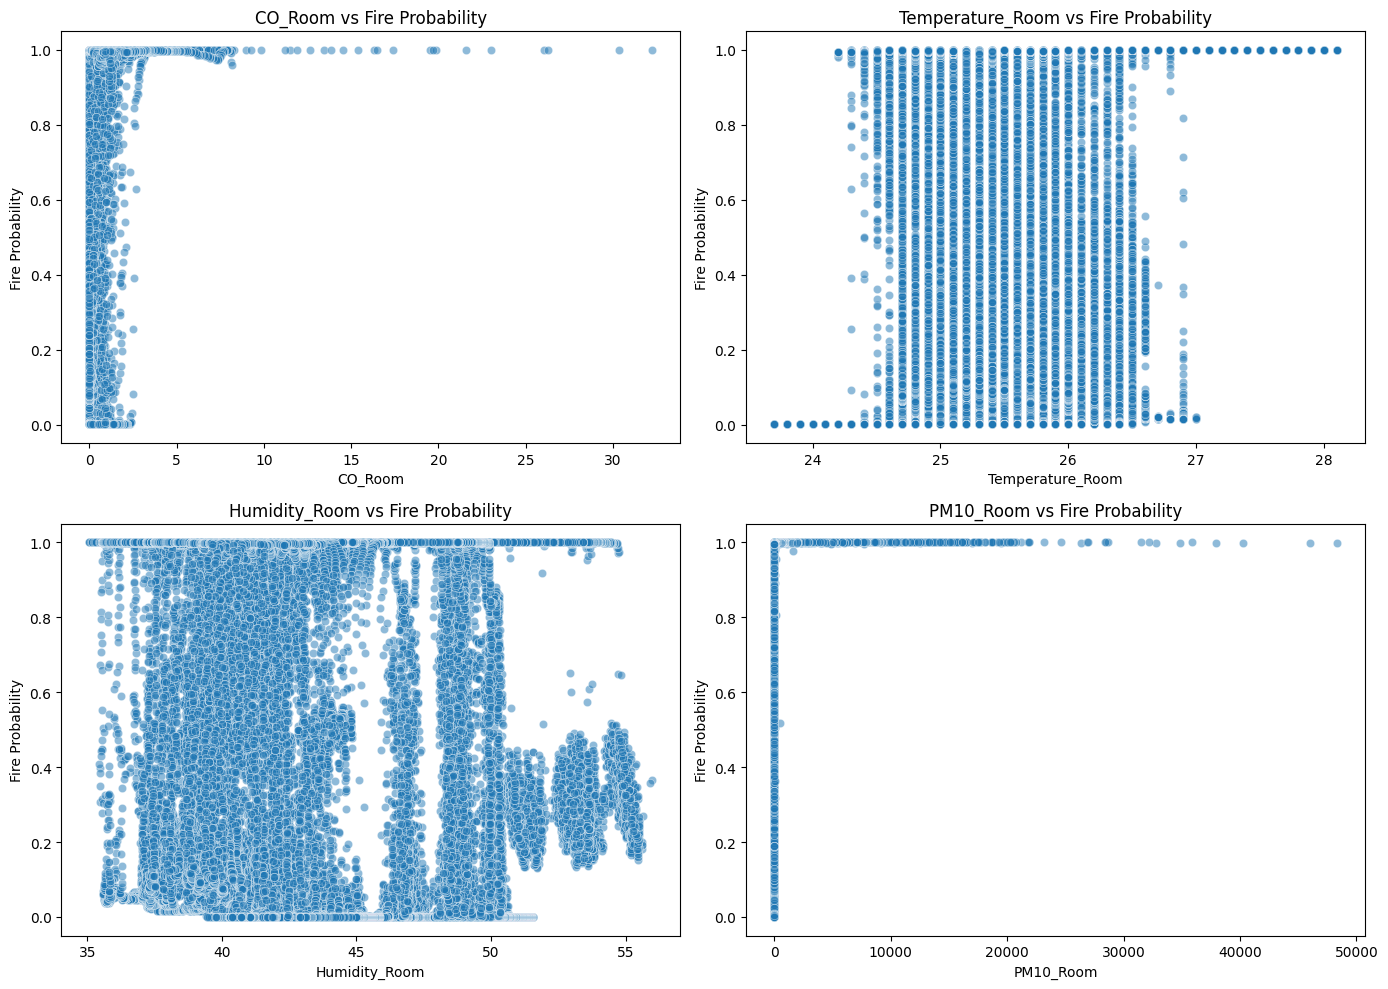

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 예측 확률 구하기
y_pred_prob = model.predict(X_seq).flatten()  # 전체 데이터 예측

# 원본 스케일로 되돌리기
X_original = scaler.inverse_transform(X_seq[:, -1, :])  # 시계열의 마지막 시점 사용
feature_names = ['CO_Room', 'Temperature_Room', 'Humidity_Room', 'PM10_Room']

# DataFrame 생성
df_plot = pd.DataFrame(X_original, columns=feature_names)
df_plot['Fire_Probability'] = y_pred_prob

# 4개 특징별 산점도
plt.figure(figsize=(14, 10))
for idx, col in enumerate(feature_names):
    plt.subplot(2, 2, idx + 1)
    sns.scatterplot(data=df_plot, x=col, y='Fire_Probability', alpha=0.5)
    plt.title(f'{col} vs Fire Probability')
    plt.xlabel(col)
    plt.ylabel('Fire Probability')
plt.tight_layout()
plt.show()


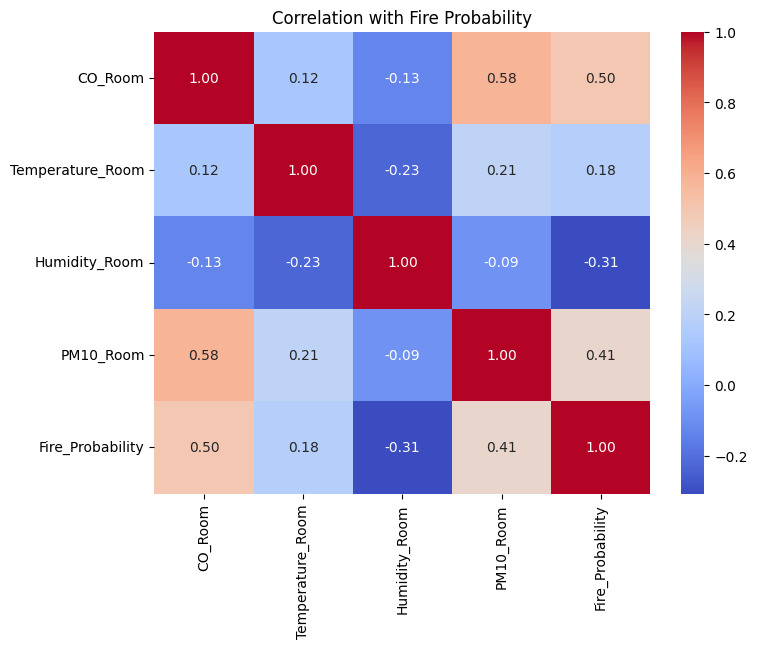

In [ ]:
corr = df_plot.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation with Fire Probability")
plt.show()

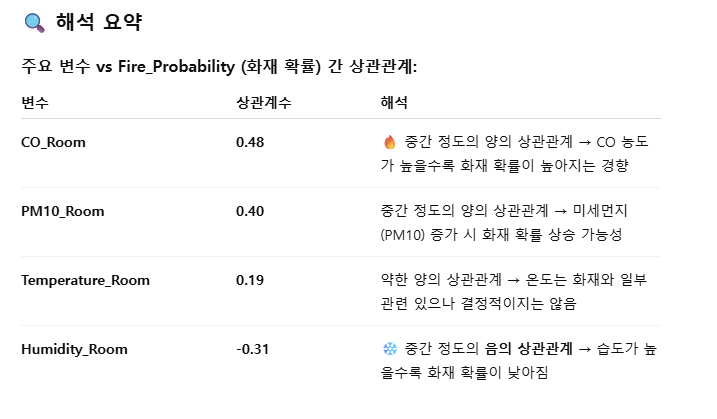

In [ ]:
pip install shap

In [ ]:
# 모델 저장
model.save('이진분류_fire_anomaly_model.h5')

AttributeError: 'LGBMClassifier' object has no attribute 'save'

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 202661, number of negative: 41582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 244243, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.829752 -> initscore=1.583867
[LightGBM] [Info] Start training from score 1.583867


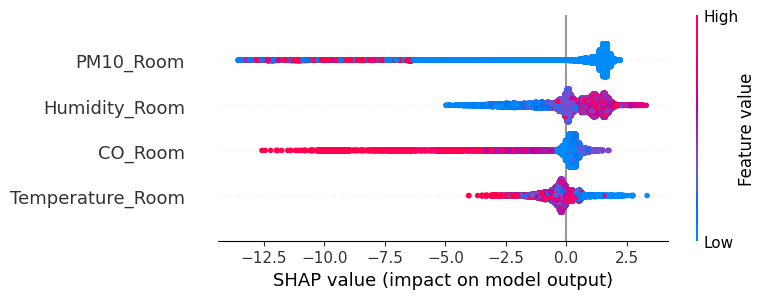

In [ ]:
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder

# 특성과 타겟 설정
features = ['CO_Room', 'Temperature_Room', 'Humidity_Room', 'PM10_Room']
X = df[features]
y = LabelEncoder().fit_transform(df['anomaly_label'])

# 정규화
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# LightGBM 모델 학습
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP 요약 플롯
shap.summary_plot(shap_values, features=X_test, feature_names=features)


In [ ]:
# 분류 리포트 및 ROC AUC
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
print("\n[분류 리포트]")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



[분류 리포트]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     10395
           1       0.98      0.99      0.98     50666

    accuracy                           0.97     61061
   macro avg       0.97      0.94      0.95     61061
weighted avg       0.97      0.97      0.97     61061

ROC AUC Score: 0.94


In [ ]:
df.info

<bound method DataFrame.info of                                    Date         Sensor_ID  CO2_Room  CO_Room  \
0      2022-07-04 14:10:54.259355+00:00  Sensorknoten0009    1150.0     0.00   
1      2022-07-04 14:10:54.401380+00:00  Sensorknoten0015    1300.0     0.00   
2      2022-07-04 14:10:55.401182+00:00  Sensorknoten0011     412.0     0.00   
3      2022-07-04 14:10:55.899093+00:00  Sensorknoten0012    1100.0     0.00   
4      2022-07-04 14:10:59.346954+00:00  Sensorknoten0016    1392.0     0.18   
...                                 ...               ...       ...      ...   
305299 2022-07-08 12:29:01.238767+00:00  Sensorknoten0011     796.0     0.92   
305300 2022-07-08 12:29:03.484557+00:00  Sensorknoten0013     652.0     1.20   
305301 2022-07-08 12:29:03.723188+00:00  Sensorknoten0014     634.0     1.17   
305302 2022-07-08 12:29:11.246358+00:00  Sensorknoten0011     792.0     0.91   
305303                              NaT  Sensorknoten0015     736.0     0.29   

        H2_Room  Humidity_Room  PM05_Room  PM100_Room  PM10_Room  PM25_Room  \
0          0.13          51.50       15.0         0.0        2.0        0.0   
1          0.12          52.85        7.0         0.0        0.0        0.0   
2          0.22          50.60       16.0         0.0        2.0        0.0   
3          0.13          52.66       13.0         0.0        1.0        0.0   
4          0.09          52.53       10.0         0.0        1.0        0.0   
...         ...            ...        ...         ...        ...        ...   
305299     0.04          39.63        7.0         0.0        1.0        0.0   
305300     0.10          41.43        6.0         0.0        1.0        0.0   
305301     0.03          41.55        6.0         0.0        0.0        0.0   
305302     0.07          39.64        7.0         0.0        1.0        0.0   
305303     0.12          44.39        7.0         0.0        0.0        0.0   

        PM40_Room  PM_Room_Typical_Size  PM_Total_Room  Temperature_Room  \
0             0.0                  0.40           17.0              26.3   
1             0.0                  0.45            8.0              25.7   
2             0.0                  0.47           19.0              26.5   
3             0.0                  0.42           15.0              25.9   
4             0.0                  0.44           11.0              26.0   
...           ...                   ...            ...               ...   
305299        0.0                  0.53            8.0              25.3   
305300        0.0                  0.56            7.0              24.5   
305301        0.0                  0.53            7.0              24.4   
305302        0.0                  0.53            8.0              25.4   
305303        0.0                  0.42            8.0              24.9   

        UV_Room  VOC_Room_RAW scenario_label anomaly_label ternary_label  \
0           0.0           0.5     Background        normal    Background   
1           0.0           0.5     Background        normal    Background   
2           0.0           0.5     Background        normal    Background   
3           0.0           0.6     Background        normal    Background   
4           0.0           0.5     Background        normal    Background   
...         ...           ...            ...           ...           ...   
305299      0.0           0.8      Deodorant       anomaly      Nuisance   
305300      0.0           0.5      Deodorant       anomaly      Nuisance   
305301      0.0           0.7      Deodorant       anomaly      Nuisance   
305302      0.0           0.8      Deodorant       anomaly      Nuisance   
305303      0.0           0.4     Background        normal    Background   

        label  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
305299      1  
305300      1  
305301      1  
305302      1  
305303      0  

[305304 rows x 20 columns]>

In [ ]:
df.dtypes

,0
Date,"datetime64[ns, UTC]"
Sensor_ID,object
CO2_Room,float64
CO_Room,float64
H2_Room,float64
Humidity_Room,float64
PM05_Room,float64
PM100_Room,float64
PM10_Room,float64
PM25_Room,float64


In [ ]:
df.to_csv('sensor_data.txt', sep = '\t', index = False)